In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_сifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
models_cifar_scratch_path = os.path.join(cwd, '..', 'models_cifar10')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_сifar)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

In [3]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from functools import partial

from dataloader import get_loader
from trainer import Trainer
from discriminator import Discriminator
from generator import Generator
from cifar10_utils import (plot_images, 
                           save_images_for_fid,
                           save_images_for_fid_fix_latent,
                           z_transform,
                           delete_local_files,
                           delete_saved_files_for_cifar10_statistics,
                           calculate_cifar10_statistics,
                           plot_scores_cifar10_dynamics)

from params_cifar10 import args
from general_utils import to_var, DotDict, to_np

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from metrics import inception_score
from dataloader import GenDataset, LatentFixDataset

In [4]:
from fid_score import calculate_fid_given_paths
from kid_score import calculate_kid_given_paths
from params_cifar10 import args

In [5]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from dcgan import (Discriminator_cifar10, 
                   Discriminator_cifar10_logits,
                   Generator_cifar10)

D = Discriminator_cifar10(ngpu=1).eval()
G = Generator_cifar10(ngpu=1).eval()
D_logits = Discriminator_cifar10_logits(D, ngpu=1).eval()

# load weights
D.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netD_epoch_199.pth')))
G.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netG_epoch_199.pth')))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    D = D.to(device)
    G = G.to(device)
    D_logits = D_logits.to(device)
    
G.z_dim = 100
G.device = device
z_dim = 100

In [6]:
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

def z_transform(z):
    return z.unsqueeze(-1).unsqueeze(-1)

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D_logits, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob,
                     z_transform = z_transform)

In [7]:
random_seed = 42

In [8]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
#z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n, n_steps, grad_step, eps_scale)

In [9]:
from sir_ais_sampling import sir_independent_dynamics, sir_correlated_dynamics
from ebm_sampling import sampling_f

In [10]:
batch_size = 250
n_steps = 1000

In [11]:
class WrapDist(nn.Module):
    def __init__(self, dist_log_prob):
        super().__init__()
        self.dist_log_prob = dist_log_prob
    
    def log_prob(self, x):
        return self.dist_log_prob(x)

    def sample(self, n):
        return self.dist_log_prob.sample(n)

In [12]:
n = 50000# // batch_size * 1000

In [13]:
from pathlib import Path

samples_dir = Path(Path.home(), 'samples')
samples_dir.mkdir(exist_ok=True)

In [14]:
from tqdm import trange
N = 10

_, zs = sampling_f(sir_independent_dynamics, WrapDist(target_gan), proposal, 
               batch_size, n, path_to_save=samples_dir,
               file_name=f'itersir_N_{N}', every_step=50, n_steps=n_steps, N=N)

0, 100)
100%|██████████| 200/200 [10:44:22<00:00, 193.31s/it]file /home/lagutin/samples/itersir_N_10_batch_num_49750.npy was saved, file shape = (21, 250, 100)



In [33]:
from tqdm import trange
N = 10

c = 1.0
dim = 128
alpha = (1 - c/dim)**0.5
_, zs = sampling_f(sir_correlated_dynamics, WrapDist(target_gan), proposal, 
               batch_size, n, path_to_save=samples_dir,
               file_name=f'citersir_N_{N}', every_step=5, n_steps=n_steps, N=N, alpha=alpha)

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 10.92 GiB total capacity; 184.35 MiB already allocated; 132.38 MiB free; 208.00 MiB reserved in total by PyTorch)

In [14]:
from ebm_sampling import load_data_from_batches

In [15]:
N = 10

path_to_save = samples_dir
path_to_batches = f'citersir_N_{N}'

In [16]:
z_agg_step = load_data_from_batches(n, batch_size, 
                           path_to_save, path_to_batches)

100%|██████████| 200/200 [00:01<00:00, 156.14it/s]


In [17]:
z_agg_step = z_agg_step[::10, ...]

In [18]:
z_agg_step.shape

(21, 50000, 100)

In [19]:
# inter_zs = zs[:, ::5, ...]
# inter_zs = inter_zs.reshape(inter_zs.shape[1], inter_zs.shape[0]*inter_zs.shape[2], -1)
#z_agg_step = z_agg_step[:, :50000, :]

In [16]:
from cifar10_utils import calculate_cifar10_statistics

In [17]:
path_to_save_cifar10 = Path('../samples/cifar10/downloaded_dataset')
path_to_save_cifar10_np = Path('../samples/cifar10/numpy_files')

In [22]:
from torchvision import datasets

_ = datasets.CIFAR10(root=path_to_save_cifar10, download=True)

Files already downloaded and verified


In [25]:
batch_size = 64

dict_results = calculate_cifar10_statistics(z_agg_step, G, 
                                 device, batch_size, 
                                 path_to_save_cifar10,
                                 path_to_save_cifar10_np,
                                 method_name='citersir',
                                 random_seed = 42,
                                 every_step = 50)

------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
iter_sir mean inception score = 5.423795185072381, std inception score = 0.027978523582144227
time for inception calculation = 170.967s
start to calculate FID score for test CIFAR10...
shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)
FID: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it, mean=40.4]FID score for test CIFAR10 with iter_sir: mean 40.391724775920714, score 0.4756369676607239
time for FID calculation on test = 95.151s
start to calculate FID score for train CIFAR10...

shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)
FID: 100%|██████████| 10/10 [01:02<00:00,  6.29s/it, mean=35.6]
FID score for train CIFAR10 with iter_sir: mean 35.589358568578476, score 0.28036313760959913
time for FID 

In [18]:
method = 'citersir'

fid_scores_mean_train = np.load(Path(path_to_save_cifar10_np, f'{method}_fid_scores_mean_train.npy'))
fid_scores_mean_test = np.load(Path(path_to_save_cifar10_np, f'{method}_fid_scores_mean_test.npy'))
fid_scores_std_train = np.load(Path(path_to_save_cifar10_np, f'{method}_fid_scores_std_train.npy'))
fid_scores_std_test = np.load(Path(path_to_save_cifar10_np, f'{method}_fid_scores_std_test.npy'))

inception_scores_mean = np.load(Path(path_to_save_cifar10_np, f'{method}_inception_scores_mean.npy'))
inception_scores_std = np.load(Path(path_to_save_cifar10_np, f'{method}_inception_scores_std.npy'))

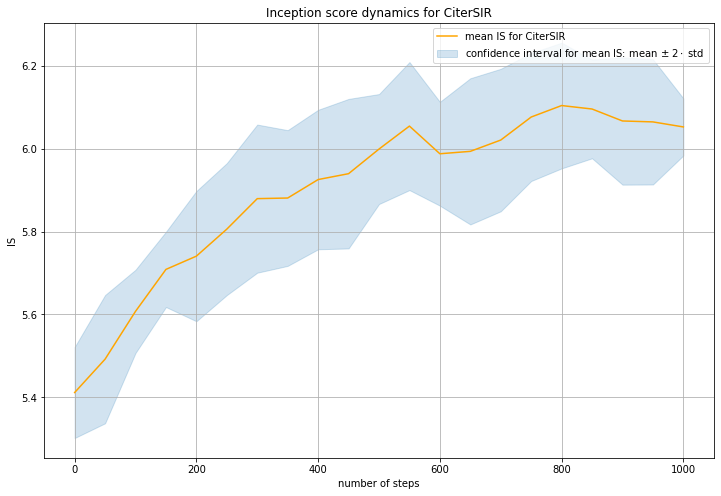

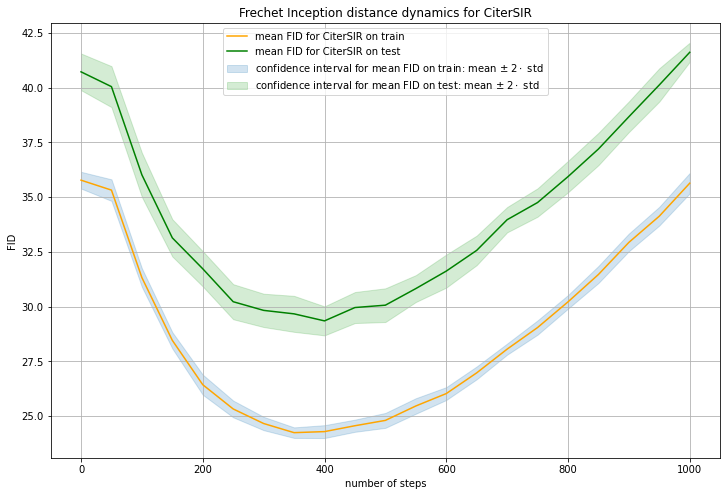

In [19]:
method_name = "CiterSIR"
figsize = (12, 8)
every_step = 50
path_to_np_files = path_to_save_cifar10_np
dict_results = dict(inception_scores_mean=inception_scores_mean,
    inception_scores_std=inception_scores_std,
    fid_scores_mean_train=fid_scores_mean_train,
    fid_scores_mean_test=fid_scores_mean_test,
    fid_scores_std_train=fid_scores_std_train,
    fid_scores_std_test=fid_scores_std_test)
plot_scores_cifar10_dynamics(dict_results,
                                 every_step, method_name,
                                 figsize,
                                 path_to_np_files,
                                 grad_step=0,
                                 eps_scale=0,
                                 coef = 2.0)

In [33]:
zs = zs.unsqueeze(0).detach().cpu().numpy()

In [34]:
method_name = f'sir_N_{N}'
path_to_save_cifar10_np = os.path.join(cwd, '..', 'samples', 'cifar10', 'numpy_files')
history_file_name_ula = f'{method_name}_nsteps_{n_steps}.npy'
file_name = os.path.join(path_to_save_cifar10_np, history_file_name_ula)
np.save(file_name, zs)

In [1]:
!nvidia-smi

Mon Apr 12 15:23:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   43C    P0    73W / 250W |      2MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   